In [2]:

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
 
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
 
AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

2024-06-16 05:08:16.734703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 05:08:16.780361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 05:08:16.781215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 05:08:17.690142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:

images = glob('data/*/*.jpg')
len(images)

418

In [4]:
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,data/benign/39.jpg,benign
1,data/benign/42.jpg,benign
2,data/benign/12.jpg,benign
3,data/benign/25.jpg,benign
4,data/benign/35.jpg,benign


In [5]:
df['label'] = df['label'].str.replace('ISIC-', '')
#df.head(50)

random_sample = df.sample(n=25)
print(random_sample)

                              filepath      label
187             data/malignant/135.jpg  malignant
185             data/malignant/289.jpg  malignant
117  data/ISIC-benign/ISIC_8590029.jpg     benign
121  data/ISIC-benign/ISIC_1488253.jpg     benign
380              data/malignant/78.jpg  malignant
205             data/malignant/220.jpg  malignant
136  data/ISIC-benign/ISIC_1816574.jpg     benign
162  data/ISIC-benign/ISIC_3615362.jpg     benign
329             data/malignant/137.jpg  malignant
399             data/malignant/216.jpg  malignant
18                  data/benign/41.jpg     benign
5                    data/benign/6.jpg     benign
106  data/ISIC-benign/ISIC_9389788.jpg     benign
140  data/ISIC-benign/ISIC_0520507.jpg     benign
192              data/malignant/98.jpg  malignant
302             data/malignant/230.jpg  malignant
270              data/malignant/50.jpg  malignant
160  data/ISIC-benign/ISIC_0921082.jpg     benign
225             data/malignant/294.jpg  malignant


In [6]:

df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,data/benign/39.jpg,benign,0
1,data/benign/42.jpg,benign,0
2,data/benign/12.jpg,benign,0
3,data/benign/25.jpg,benign,0
4,data/benign/35.jpg,benign,0


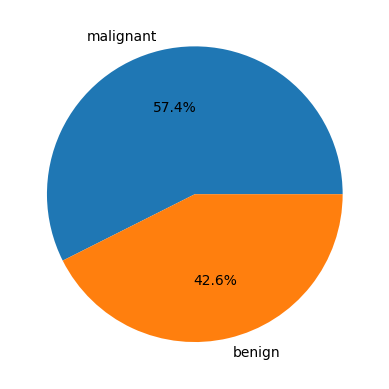

In [7]:

x = df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

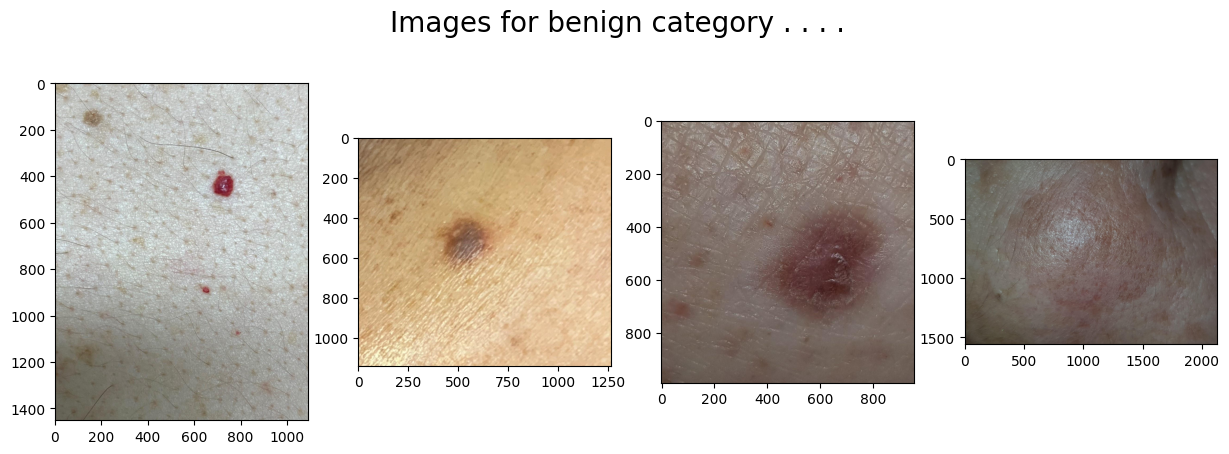

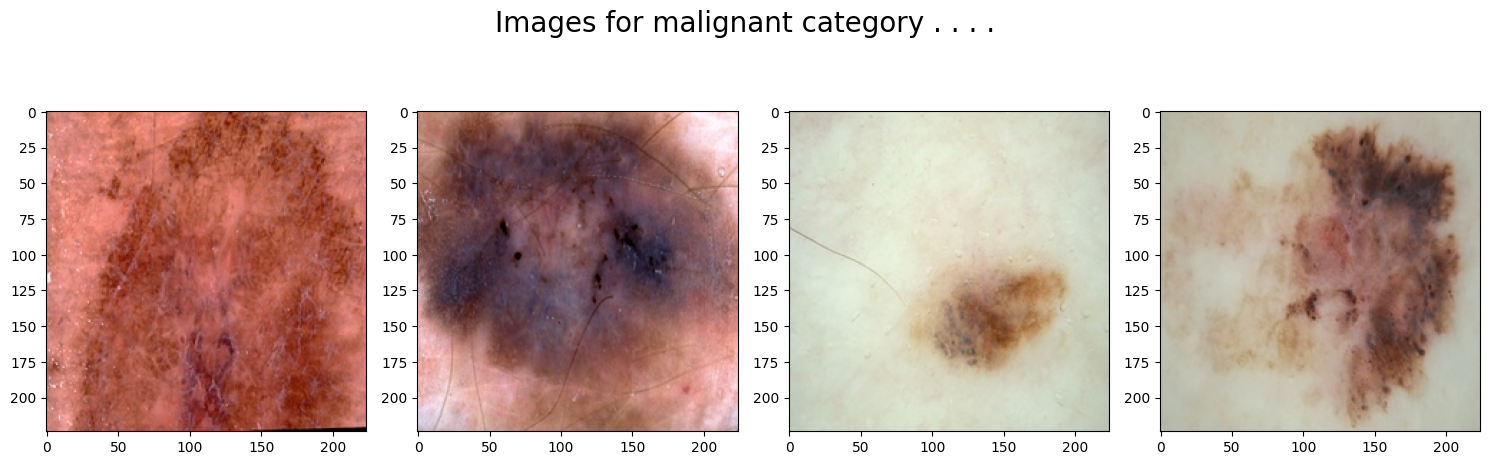

In [8]:

for cat in df['label'].unique():
    temp = df[df['label'] == cat]
 
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]
 
        image_path = data[0]
 
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [16]:

features = df['filepath']
target = df['label']
 
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)
 
#X_train.shape, X_val.shape, Y_train.shape , Y_val.shape
#Y_val.head()

In [26]:
tdy = list(Y_train)
tdx = list(X_train)

len(set(tdx) - set(tdy))

355

In [17]:

def decode_image(filepath, label):
 
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    
    print('label:', label)
    if label == 'benign':
        Label = 0
    else:
        Label = 1
 
    return img, Label
    return img




In [ ]:
# def decode_image(filepath, label=None):
 
#     img = keras.utils.load_img(filepath, target_size=(224, 224))
#     x = keras.utils.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)


#     print(x) 
#     return x

In [18]:

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)
 
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


print(train_ds)

label: Tensor("args_1:0", shape=(), dtype=string)
label: Tensor("args_1:0", shape=(), dtype=string)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [19]:


from tensorflow.keras.applications.efficientnet import EfficientNetB7
 
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
 
for layer in pre_trained_model.layers:
    layer.trainable = False

In [20]:

from tensorflow.keras import Model
 
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)
 
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
 
model = Model(inputs, outputs)

In [21]:

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['AUC']
)

In [22]:

history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    verbose=1)

Epoch 1/5
12/12 [==============================] - 7s 488ms/step - loss: 0.6708 - auc: 0.7077 - val_loss: 1.1726 - val_auc: 0.7236
Epoch 2/5
12/12 [==============================] - 6s 468ms/step - loss: 0.5685 - auc: 0.7989 - val_loss: 1.0122 - val_auc: 0.6618
Epoch 3/5
12/12 [==============================] - 6s 467ms/step - loss: 0.4764 - auc: 0.8540 - val_loss: 1.8376 - val_auc: 0.6501
Epoch 4/5
12/12 [==============================] - 6s 479ms/step - loss: 0.3707 - auc: 0.9140 - val_loss: 0.9924 - val_auc: 0.7333
Epoch 5/5
12/12 [==============================] - 6s 507ms/step - loss: 0.3735 - auc: 0.9128 - val_loss: 0.8832 - val_auc: 0.7571


In [23]:

hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,auc,val_loss,val_auc
0,0.670761,0.707695,1.172636,0.723631
1,0.568506,0.798853,1.012208,0.661765
2,0.476383,0.853978,1.837614,0.650101
3,0.370735,0.913990,0.992351,0.733266
4,0.373522,0.912849,0.883239,0.757099


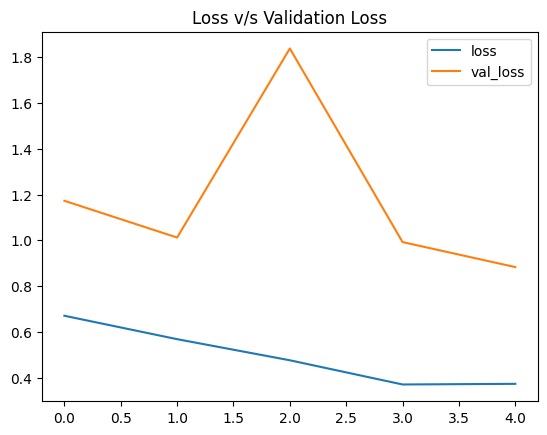

In [24]:

hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()


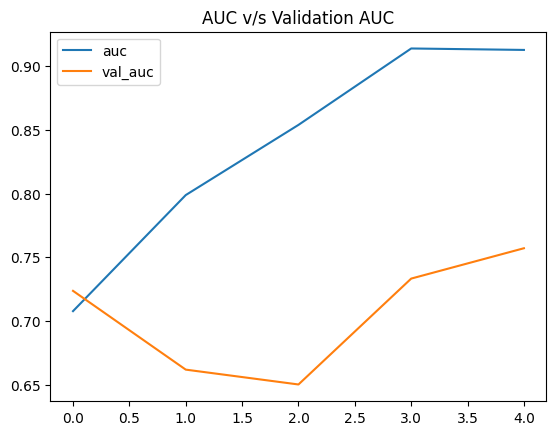

In [25]:

hist_df['auc'].plot()
hist_df['val_auc'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()
